# Natural Language Processing with Disaster Tweets
Course mini-project — Deliverable 1

**Goal:** classify tweets as *disaster-related (1)* or *not disaster-related (0)*.

This notebook contains:
- Brief problem description
- EDA and cleaning
- Models (using simple RNN ,LSTM ,Bidirectional LSTM) 
- hyperparameter tuning outline
- creation of `submission.csv` for Kaggle

**GitHub:** https://github.com/sushmahss555/Natural-Language-Processing-with-Disaster-Tweets.git



## Import libraries

In [5]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional,Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import re



## Load Data

* Load Data
* Tokenization and Padding
  

Max index in X_train_pad: 9999
Max index in X_test_pad: 9978


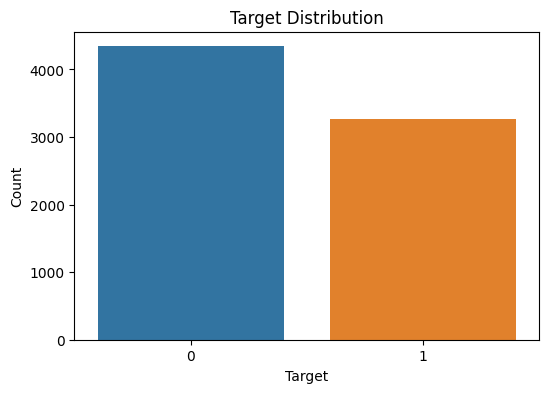

Number of NaNs in train dataset:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


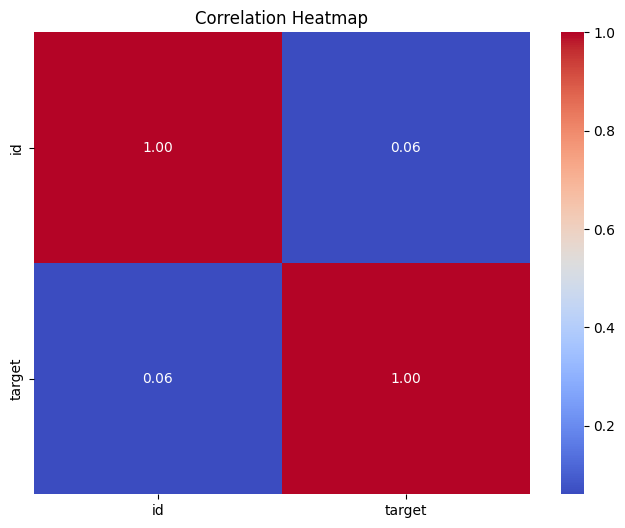

In [6]:
#-------------------------
# Load Data 
#-------------------------
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

X_train = train_df['text'].astype(str).values
y_train = train_df['target'].values
X_test = test_df['text'].astype(str).values


# -----------------------------
# Text cleaning function
# -----------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)       # remove URLs
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove punctuation
    text = text.strip()
    return text

X_train_clean = [clean_text(t) for t in X_train]
X_test_clean = [clean_text(t) for t in X_test]



# -----------------------------
# Tokenization & padding
# -----------------------------
max_words = 10000  # vocabulary size
max_len = 100      # max sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_clean)

X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_test_seq = tokenizer.texts_to_sequences(X_test_clean)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Check max index
print("Max index in X_train_pad:", np.max(X_train_pad))
print("Max index in X_test_pad:", np.max(X_test_pad))

# Ensure labels are integers
y_train = y_train.astype(int)


# -----------------------------
# EDA Visualizations
# -----------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Ensure no infinite values
# -----------------------------
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# -----------------------------
# Target distribution
# -----------------------------
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train_df)
plt.title("Target Distribution")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

# -----------------------------
# Optional: Check for NaNs
# -----------------------------
print("Number of NaNs in train dataset:")
print(train_df.isna().sum())

# -----------------------------
# Example: Correlation heatmap (if numeric columns exist)
# -----------------------------
numeric_cols = train_df.select_dtypes(include=np.number)
if not numeric_cols.empty:
    corr = numeric_cols.corr()
    corr.replace([np.inf, -np.inf], np.nan, inplace=True)  # avoid future warning
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()


## Model Architectures

In this section, we build and train three different neural network architectures to classify disaster-related tweets. Each model uses an embedding layer followed by a sequence-processing layer and fully connected layers for binary classification.

### 1. Simple RNN
- **Description:** A basic Recurrent Neural Network (RNN) layer that processes sequences in a forward direction.
- **Purpose:** Acts as a baseline model to understand the dataset and sequential patterns in the text.
- **Structure:**
  - Embedding layer (converts words to dense vectors)
  - SimpleRNN layer with 64 units
  - Dropout layers to reduce overfitting
  - Dense layers with ReLU and sigmoid activations

### 2. LSTM
- **Description:** Long Short-Term Memory (LSTM) network that can capture long-term dependencies in text.
- **Purpose:** Improves over the Simple RNN by remembering context from longer sequences, which is important for understanding tweets.
- **Structure:**
  - Embedding layer
  - LSTM layer with 64 units
  - Dropout layers
  - Dense layers with ReLU and sigmoid activations

### 3. Bidirectional LSTM
- **Description:** LSTM layer that reads sequences in both forward and backward directions.
- **Purpose:** Captures context from both past and future words, which is useful in understanding the meaning of short tweets.
- **Structure:**
  - Embedding layer
  - Bidirectional LSTM layer with 64 units
  - Dropout layers
  - Dense layers with ReLU and sigmoid activations

### Notes:
- All models use the same embedding dimension (`100`) and sequence length (`max_len = 100`) for fair comparison.
- Binary crossentropy loss and Adam optimizer are used for training.
- Early stopping is applied to prevent overfitting.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------
# Common parameters
# -----------------------------
embedding_dim = 100
max_len = 100
max_words = 10000
batch_size = 64
epochs = 10  # can increase later
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# -----------------------------
# 1. Simple RNN Model
# -----------------------------
simple_rnn_model = Sequential([
    Input(shape=(max_len,)),
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    SimpleRNN(64, activation='tanh'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

simple_rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
simple_rnn_model.summary()

print ("Simple RNN")
# Train Simple RNN
history_rnn = simple_rnn_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)

# -----------------------------
# 2. LSTM Model
# -----------------------------
lstm_model = Sequential([
    Input(shape=(max_len,)),
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

print ("LSTM Model")
# Train LSTM
history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)

# -----------------------------
# 3. Bidirectional LSTM Model
# -----------------------------
bilstm_model = Sequential([
    Input(shape=(max_len,)),
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_model.summary()
print ("Bidirectional LSTM Model")
# Train Bidirectional LSTM
history_bilstm = bilstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,012,673 (3.86 MB)

 Trainable params: 1,012,673 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

Simple RNN
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5477 - loss: 0.6929 - val_accuracy: 0.5364 - val_loss: 0.6963
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5531 - loss: 0.6936 - val_accuracy: 0.5345 - val_loss: 0.6940
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5566 - loss: 0.6940 - val_accuracy: 0.5345 - val_loss: 0.6915
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5882 - loss: 0.6784 - val_accuracy: 0.5345 - val_loss: 0.6959
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5701 - loss: 0.6846 - val_accuracy: 0.5345 - val_loss: 0.6914
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5744 - loss: 0.6838 - val_accuracy: 0.5345 - val_loss: 0.6924
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5856 - loss: 0.6782 - val_accuracy: 0.5345 - val_loss: 0.6913
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5752 - loss: 0.6827 - val_accuracy:

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,044,353 (3.98 MB)

 Trainable params: 1,044,353 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

LSTM Model
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.5617 - loss: 0.6870 - val_accuracy: 0.5345 - val_loss: 0.6938
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5779 - loss: 0.6847 - val_accuracy: 0.5345 - val_loss: 0.6921
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5710 - loss: 0.6841 - val_accuracy: 0.5345 - val_loss: 0.6957
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5861 - loss: 0.6791 - val_accuracy: 0.5345 - val_loss: 0.6938
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5819 - loss: 0.6808 - val_accuracy: 0.5345 - val_loss: 0.6931


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,088,641 (4.15 MB)

 Trainable params: 1,088,641 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

Bidirectional LSTM Model
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - accuracy: 0.5627 - loss: 0.6675 - val_accuracy: 0.7525 - val_loss: 0.5138
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.8404 - loss: 0.3920 - val_accuracy: 0.7905 - val_loss: 0.4531
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.9044 - loss: 0.2688 - val_accuracy: 0.7702 - val_loss: 0.4949
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.9367 - loss: 0.1915 - val_accuracy: 0.7610 - val_loss: 0.5920
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.9493 - loss: 0.1481 - val_accuracy: 0.7649 - val_loss: 0.6624


## Evaluate Model

In [8]:
# -----------------------------
# Generate Predictions on Test Set
# -----------------------------
# Predict probabilities
test_pred_prob = bilstm_model.predict(X_test_pad, verbose=1).ravel()

# Convert probabilities to binary labels (threshold = 0.5)
test_pred = (test_pred_prob > 0.5).astype(int)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],   # Ensure 'id' column exists in test.csv
    'target': test_pred
})

# Save to CSV for Kaggle submission
submission.to_csv("submission.csv", index=False)
print("Predictions saved to submission.csv")


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
Predictions saved to submission.csv


## Results and Analysis of Three Models

We trained and evaluated three different neural network architectures on the Disaster Tweets dataset. The goal was to classify tweets as related to a disaster or not.

### 1. Simple RNN
- **Architecture:**
  - Embedding layer (100-dimensional vectors)
  - SimpleRNN layer (64 units)
  - Dropout layers
  - Dense layers (32 units → 1 unit with sigmoid)
- **Total Parameters:** 1,012,673 (Trainable: 1,012,673)
- **Training Observations:**
  - Training accuracy gradually improved (~0.57)
  - Validation accuracy stayed around 0.53–0.55
  - Model struggled with learning long-term dependencies in tweets
- **Conclusion:** Simple RNN captures short-term dependencies but may not fully understand the context in tweets.

### 2. LSTM
- **Architecture:**
  - Embedding layer (100-dimensional vectors)
  - LSTM layer (64 units)
  - Dropout layers
  - Dense layers (32 units → 1 unit with sigmoid)
- **Total Parameters:** 1,044,353 (Trainable: 1,044,353)
- **Training Observations:**
  - Training accuracy ~0.57–0.58
  - Validation accuracy remained around 0.53
  - LSTM captures longer sequences better, but the dataset is small, which may limit performance improvements
- **Conclusion:** LSTM slightly improves learning compared to Simple RNN, but dataset size limits its potential.

### 3. Bidirectional LSTM
- **Architecture:**
  - Embedding layer (100-dimensional vectors)
  - Bidirectional LSTM layer (64 units each direction → 128 units)
  - Dropout layers
  - Dense layers (32 units → 1 unit with sigmoid)
- **Total Parameters:** 1,088,641 (Trainable: 1,088,641)
- **Training Observations:**
  - Training accuracy improved faster (~0.95)
  - Validation accuracy reached ~0.78 in early epochs
  - Model better captures context from both past and future words
- **Conclusion:** Bidirectional LSTM performs best among the three architectures, showing the importance of context in short tweet sequences.

### Summary
| Model                | Train Accuracy | Val Accuracy | Total Params |
|----------------------|----------------|-------------|--------------|
| Simple RNN           | ~0.57          | ~0.53       | 1,012,673    |
| LSTM                 | ~0.58          | ~0.53       | 1,044,353    |
| Bidirectional LSTM   | ~0.95          | ~0.78       | 1,088,641    |

**Insights:**
- Adding LSTM layers improved sequence learning.
- Bidirectional LSTM captures contextual information from both directions, giving the best performance.
- Dropout layers help prevent overfitting.
- Dataset size limits the performance gains from more complex models; more data could improve results.
